In [1]:
from builtins import sorted
import ffmpeg
import librosa
import librosa.display
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore') #for reading mp3

#librosa==0.7.2
#numba==0.43

In [2]:
genres_list = ['disco', 'reggae', 'pop', 'rock',
               'metal', 'jazz', 'blues', 'hiphop', 'country']

template_types = ['binary', 'ks', 'harmonic']
chroma_operations = ['stft', 'cqt', 'cens']

binary_correct_accumulate_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                                  'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

binary_file_num_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                        'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

moving_scale = {0: '15', 1: '16', 2: '17', 3: '18', 4: '19', 5: '20',
                6: '21', 7: '22', 8: '23', 9: '0', 10: '1', 11: '2',
                12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8',
                18: '9', 19: '10', 20: '11', 21: '12', 22: '13', 23: '14',
                }

# ground_truth_major_scale = ['A', 'A#', 'B', 'C', 'C#','D',
#                           'D#', 'E', 'F', 'F#', 'G', 'G#']

# ground_truth_minor_scale = ['a', 'a#', 'b', 'c', 'c#', 'd',
#                           'd#', 'e', 'f', 'f#', 'g', 'g#']

annotation_major_scale = {'A':0, 'A#':1, 'Bb':1, 'B':2, 'C':3, 'C#':4, 'Db':4,'D':5,
                          'D#':6, 'Eb':6, 'E':7, 'F':8, 'F#':9, 'Gb':9, 'G':10, 'G#':10, 'Ab':11}

annotation_minor_scale = {'a':12, 'a#':13, 'bb':13, 'b':14, 'c':15, 'c#':16, 'db':16, 'd':17,
                          'd#':18, 'eb':18, 'e':19, 'f':20, 'f#':21, 'gb':21, 'g':22, 'g#':23, 'ab':23}

octave_scale = ['C', 'C#', 'D', 'D#', 'E', 'F',
                'F#', 'G', 'G#', 'A', 'A#', 'B']

file_type = ['HU33', 'SC06', 'FI66', 'FI80', 'midi']


In [3]:
# -- 1) binary-valued template matching
# -- 2) K-S template matching
# -- 3) harmonic template matching (try 𝛼 = 0.9).
# -- Using Cicular Shifting to generate another tone

binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# -- C, C#, D, D#, E, F, F#, G, G#, A, A#, B
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38,
              4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60,
              3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

binary_templates = [binary_C_major, binary_C_minor]
ks_templates = [KS_C_major, KS_C_minor]

alpha = 0.9

# C Major harmonic template
C_major_harmonic_template = [1 + alpha + alpha**3 + alpha**7, 0, 0, 0, alpha**4, 0,
                             0, alpha**2+alpha**5, 0, 0, alpha**6, 0]

all_pitches_harmonic_template = [0] * 12

# Get all pitchs harmonic template
for i in range(12):
    all_pitches_harmonic_template[i] = np.roll(C_major_harmonic_template, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += all_pitches_harmonic_template[(i + 3) % 12]

for i in range(12):
    if binary_templates[1][i] == 1:
        harmonic_minor_template += all_pitches_harmonic_template[(i + 3) % 12]

harmonic_templates = [harmonic_major_template, harmonic_minor_template]

templates = {'binary':binary_templates, 'ks':ks_templates, 'harmonic':harmonic_templates}

In [4]:
# audio 調式標記
audio_path = "./HW1 Datasets/SWD/SWD/02_Annotations/ann_audio_globalkey.csv"
audio_global_key_df = pd.read_csv(audio_path, sep=";")

# midi 樂譜調式標記
score_path = "./HW1 Datasets/SWD/SWD/02_Annotations/ann_score_globalkey.csv"
score_global_key_df = pd.read_csv(score_path, sep=";")

In [5]:
def replace_key(row):
    if (row.find('maj') != -1):
        return annotation_major_scale[row.split(':')[0]]
    elif (row.find('min') != -1):
        return annotation_minor_scale[row.split(':')[0].lower()]

In [6]:
audio_global_key_df['ann_key'] = audio_global_key_df['key'].apply(replace_key)
print(tabulate(audio_global_key_df, headers='keys', tablefmt='fancy_grid'))

╒═════╤══════════════════╤═════════════════╤════════╤═══════════╕
│     │ WorkID           │ PerformanceID   │ key    │   ann_key │
╞═════╪══════════════════╪═════════════════╪════════╪═══════════╡
│   0 │ Schubert_D911-01 │ AL98            │ C:min  │        15 │
├─────┼──────────────────┼─────────────────┼────────┼───────────┤
│   1 │ Schubert_D911-01 │ FI55            │ C:min  │        15 │
├─────┼──────────────────┼─────────────────┼────────┼───────────┤
│   2 │ Schubert_D911-01 │ FI66            │ C:min  │        15 │
├─────┼──────────────────┼─────────────────┼────────┼───────────┤
│   3 │ Schubert_D911-01 │ FI80            │ C:min  │        15 │
├─────┼──────────────────┼─────────────────┼────────┼───────────┤
│   4 │ Schubert_D911-01 │ HU33            │ C:min  │        15 │
├─────┼──────────────────┼─────────────────┼────────┼───────────┤
│   5 │ Schubert_D911-01 │ OL06            │ C:min  │        15 │
├─────┼──────────────────┼─────────────────┼────────┼───────────┤
│   6 │ Sc

In [7]:
score_global_key_df['ann_key'] = score_global_key_df['key'].apply(replace_key)
print(tabulate(score_global_key_df, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════════════╤════════╤═══════════╕
│    │ WorkID           │ key    │   ann_key │
╞════╪══════════════════╪════════╪═══════════╡
│  0 │ Schubert_D911-01 │ D:min  │        17 │
├────┼──────────────────┼────────┼───────────┤
│  1 │ Schubert_D911-02 │ A:min  │        12 │
├────┼──────────────────┼────────┼───────────┤
│  2 │ Schubert_D911-03 │ F:min  │        20 │
├────┼──────────────────┼────────┼───────────┤
│  3 │ Schubert_D911-04 │ C:min  │        15 │
├────┼──────────────────┼────────┼───────────┤
│  4 │ Schubert_D911-05 │ E:maj  │         7 │
├────┼──────────────────┼────────┼───────────┤
│  5 │ Schubert_D911-06 │ E:min  │        19 │
├────┼──────────────────┼────────┼───────────┤
│  6 │ Schubert_D911-07 │ E:min  │        19 │
├────┼──────────────────┼────────┼───────────┤
│  7 │ Schubert_D911-08 │ G:min  │        22 │
├────┼──────────────────┼────────┼───────────┤
│  8 │ Schubert_D911-09 │ B:min  │        14 │
├────┼──────────────────┼────────┼───────────┤
│  9 │ Schube

In [8]:
#['HU33', 'SC06', 'FI66', 'FI80', 'midi']
ann_dict = {}

for format in file_type:
    if format == 'midi':
        score_global_key_df
        ann_dict[format] = score_global_key_df
    else:
        ann_dict[format] = audio_global_key_df.loc[audio_global_key_df["PerformanceID"] == format]


ann_dict['midi']

,WorkID,key,ann_key
0,Schubert_D911-01,D:min,17
1,Schubert_D911-02,A:min,12
2,Schubert_D911-03,F:min,20
3,Schubert_D911-04,C:min,15
4,Schubert_D911-05,E:maj,7
5,Schubert_D911-06,E:min,19
6,Schubert_D911-07,E:min,19
7,Schubert_D911-08,G:min,22
8,Schubert_D911-09,B:min,14
9,Schubert_D911-10,C:min,15


In [9]:
audio_file_format = {"HU33":".wav", "SC06":".wav", "FI66":".mp3", "FI80":".mp3", "midi":".mid"}
def find_tonic(visualize:bool=False):
    # If exist then delete it first
    analysis_path = "./temp/SWD_analysis/"
    try:
        shutil.rmtree(analysis_path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

    for format in file_type:
        if format != "midi":
            for i in range(1, 25):
                y, sr = librosa.load(
                            r"./HW1 Datasets/SWD/SWD/01_RawData/audio_wav/" + format +
                            "/Schubert_D911-" + str(i).zfill(2) + "_" + format +
                            audio_file_format[format])
                
                # print(y.shape)
                # print(sr)
                
                # -- STFT chromagram
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=2048)

                # -- CQT chromagram
                chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
                
                # -- Chroma Energy Normalized chromagram
                chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
                # print(chroma_cens.shape)  # 12 dim pitch, 1293 frames
                
                chroma_dict = {"stft":chroma_stft, "cqt":chroma_cqt, "cens":chroma_cens}

                # -- Chromagram visualization -------------------------
                if visualize == True:
                    plt.plot(y)
                    plt.figure(figsize=(15, 15))
                    plt.subplot(3, 1, 1)
                    librosa.display.specshow(chroma_stft, y_axis='chroma')
                    plt.title('chroma_stft')
                    plt.colorbar()
                    plt.subplot(3, 1, 2)
                    librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time')
                    plt.title('chroma_cqt')
                    plt.colorbar()
                    plt.subplot(3, 1, 3)
                    librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
                    plt.title('chroma_cens')
                    plt.colorbar()
                    plt.tight_layout()

                    plt.show()
                # --------------------------------------------------
                
                # -- Save chroma ndarray ------------------------------
                for chroma_operation in chroma_operations:
                    filename = "./temp/SWD_analysis/chroma/" + format + "/" + chroma_operation + "/" + str(i).zfill(2) + ".txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, 'w') as f:
                        np.savetxt(filename, chroma_dict[chroma_operation])
                # --------------------------------------------------

                # # -- Compute x = 1/N sigma(i=1, N){Zi}
                # # -- Find tonic pitch
                for chroma_operation in chroma_operations:
                    # chroma_operations = ['stft', 'cqt', 'cens']
                    avg_chromagram = []
                    frame_n = chroma_dict[chroma_operation].shape[1]
                    for pitchs in range(chroma_dict[chroma_operation].shape[0]):
                        accumulate_value = 0
                        for frames in range(chroma_dict[chroma_operation].shape[1]):
                            accumulate_value += chroma_dict[chroma_operation][pitchs][frames]
                        avg_chromagram.append(accumulate_value/frame_n)

                    # print(avg_chromagram)
                    # print("avg_chromagram", len(avg_chromagram))
                    tonic_pitch = (np.argmax(avg_chromagram) + 3) % 12
                    #print("tonic_pitch: ", octave_scale[tonic_pitch])
                    tonic_filename = "./temp/SWD_analysis/tonic/" + format + "_" + chroma_operation + ".txt"
                    os.makedirs(os.path.dirname(tonic_filename), exist_ok=True)
                    with open(tonic_filename, 'a') as f:
                        f.write(str(tonic_pitch) + '\n')

        elif format == "midi":
            for i in range(1, 25):
                #print("midi: ", format)
                midi_data = pretty_midi.PrettyMIDI("./HW1 Datasets/SWD/SWD/01_RawData/score_midi/Schubert_D911-" + str(i).zfill(2) + audio_file_format[format])

                chroma_midi = midi_data.get_chroma()

                filename = "./temp/SWD_analysis/chroma/" + format + "/"  + str(i).zfill(2) + ".txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    np.savetxt(filename, chroma_midi)

                # # -- Compute x = 1/N sigma(i=1, N){Zi}
                # # -- Find tonic pitch
                #print("chroma_midi: ", chroma_midi)
                avg_chromagram = []
                frame_n = chroma_midi.shape[1]
                for pitchs in range(chroma_midi.shape[0]):
                    accumulate_value = 0
                    for frames in range(chroma_midi.shape[1]):
                        accumulate_value += chroma_midi[pitchs][frames]
                    avg_chromagram.append(accumulate_value/frame_n)

                # print(avg_chromagram)
                # print("avg_chromagram", len(avg_chromagram))
                tonic_pitch = (np.argmax(avg_chromagram) + 3) % 12
                #print("tonic_pitch: ", octave_scale[tonic_pitch])
                tonic_filename = "./temp/SWD_analysis/tonic/" + format + ".txt"
                os.makedirs(os.path.dirname(tonic_filename), exist_ok=True)
                with open(tonic_filename, 'a') as f:
                    f.write(str(tonic_pitch) + '\n')
    return

In [10]:
find_tonic()

In [11]:
def get_chroma(format:str, chroma_operation:str, index:int):
    if format == "midi":
        chroma_file = "./temp/SWD_analysis/chroma/" + format + "/" + str(index).zfill(2) + ".txt"
        with open(chroma_file, 'r') as f:
            return np.loadtxt(chroma_file)
    else:
        chroma_file = "./temp/SWD_analysis/chroma/" + format + "/" + chroma_operation + "/" + str(index).zfill(2) + ".txt"
        with open(chroma_file, 'r') as f:
            return np.loadtxt(chroma_file)
    

def get_tonic_pitch(file_type:list, chroma_operations:list):
    tonic_dict = {}
    for format in file_type:
        if format == "midi":
            format_tonic_file = "./temp/SWD_analysis/tonic/"
            tonic_dict[format] = {}
            filename = format_tonic_file + format + ".txt"

            with open(filename, 'r') as f:
                tonic_dict[format]["non"] = []
                for i in range(24):
                    tonic_dict[format]["non"].append(int(f.readline().rstrip()))
        else:
            format_tonic_file = "./temp/SWD_analysis/tonic/"
            tonic_dict[format] = {}
            for chroma_operation in chroma_operations:
                filename = format_tonic_file + format + "_" + chroma_operation + ".txt"
        
                with open(filename, 'r') as f:
                    tonic_dict[format][chroma_operation] = []
                    
                    for i in range(24):
                        tonic_dict[format][chroma_operation].append(int(f.readline().rstrip()))
    return tonic_dict

In [12]:
a = get_chroma("FI66", "cqt", 1)
m = get_chroma("midi", "non", 1)
print(a)
print(m)

[[0.92979908 0.95207459 0.95398211 ... 1.         1.         1.        ]
 [0.94350672 0.96470237 0.98882002 ... 0.34646839 0.46179405 0.53418386]
 [1.         1.         1.         ... 0.47746736 0.51613575 0.50121629]
 ...
 [0.46817377 0.4972319  0.53486741 ... 0.18172264 0.2146666  0.20275633]
 [0.50722551 0.54189962 0.57034773 ... 0.20773157 0.18647245 0.1829394 ]
 [0.60299003 0.63877249 0.65930909 ... 0.28695047 0.3358742  0.38504621]]
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [ 65.  65.  65. ... 126. 126. 126.]
 ...
 [ 65.  65.  65. ...  84.  84.  84.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [13]:
tonic_pitches_dict = get_tonic_pitch(file_type, chroma_operations)
tonic_pitches_dict['FI66']['cqt'][1]

5

In [14]:
tonic_pitches_dict['midi']['non'][1]

7

In [15]:
def predict_global_key(chroma, major_template, minor_template, tonic_pitch: int):
    # compute x = 1/N sigma(i=1, N){Zi}
    avg_chromagram = []
    frame_n = chroma.shape[1]
    for pitches in range(chroma.shape[0]):
        accumulate_value = 0
        for frames in range(chroma.shape[1]):
            accumulate_value += chroma[pitches][frames]
        avg_chromagram.append(accumulate_value/frame_n)

    # Just compare with tonic pitch's Major and minor chromagram
    major_corelation_coefficient = stats.pearsonr(avg_chromagram, np.roll(major_template, -3 + tonic_pitch))[0]
    minor_corelation_coefficient = stats.pearsonr(avg_chromagram, np.roll(minor_template, -3 + tonic_pitch))[0]

    if major_corelation_coefficient > minor_corelation_coefficient:
        # Major
        return tonic_pitch
    else:
        # minor
        return tonic_pitch+12

def predict(file_type:list, chroma_operations:list, tonic_pitches_dict:dict):
    predict_path = "./temp/SWD_analysis/predict/"
    for format in file_type:
        if format == "midi":
            predict_type_path = predict_path + "/" + format + "/"

            for template_type in template_types:
                filename = predict_type_path + template_type + ".txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    for i in range(24):
                        predict_key = predict_global_key(
                                        get_chroma(format, "non", i+1),
                                        templates[template_type][0],
                                        templates[template_type][1],
                                        tonic_pitches_dict[format]["non"][i]
                                    )
                        f.write(str(predict_key) + '\n')
        else:
            predict_type_path = predict_path + "/" + format + "/"
            for chroma_operation in chroma_operations:
                predict_type_chroma_path = predict_type_path + "/" + chroma_operation + "/"
                for template_type in template_types:
                    filename = predict_type_chroma_path + template_type + ".txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, mode='w') as f:
                        for i in range(24):
                            predict_key = predict_global_key(
                                            get_chroma(format, chroma_operation, i+1),
                                            templates[template_type][0],
                                            templates[template_type][1],
                                            tonic_pitches_dict[format][chroma_operation][i]
                                        )
                            f.write(str(predict_key) + '\n')
    return

In [16]:
a_test = predict_global_key(get_chroma('FI66', 'cqt', 5), binary_templates[0], binary_templates[1], tonic_pitches_dict['FI66']['cqt'][0])
print(a_test)

3


In [17]:
predict(file_type, chroma_operations, tonic_pitches_dict)

In [18]:
print(list(ann_dict['HU33']['ann_key']))

[15, 22, 17, 12, 7, 17, 17, 20, 12, 14, 10, 14, 3, 14, 14, 5, 5, 17, 0, 20, 8, 21, 10, 22]


In [19]:
def raw_accuracy(predictions, ground_truth):
    score = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return round(score / len(ground_truth), 5)

def weighted_accuracy(predictions, ground_truth):
    score = 0
    weighted_fifth_count = 0
    weighted_relative_count = 0
    weighted_parallel_count = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
        elif (predictions[i] + 7) % 12 == ground_truth[i]:
            score += 0.5 # perfect fifth
            weighted_fifth_count += 1
        elif predictions[i] < 12:
            if predictions[i] + 9 == ground_truth[i]:
                score += 0.3 # relative Major
                weighted_relative_count += 1
            elif predictions[i] + 12 == ground_truth[i]:
                score += 0.2 # parallel Major
                weighted_parallel_count += 1
        elif predictions[i] >= 12:
            if (predictions[i] + 3) % 12 == ground_truth[i]:
                score += 0.3 # relative minor
                weighted_relative_count += 1
            elif predictions[i] - 12 == ground_truth[i]:
                score += 0.2 # parallel minor
                weighted_parallel_count += 1
    #print("ground_truth:", ground_truth, " [weight]", weighted_fifth_count, weighted_relative_count, weighted_parallel_count)
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return [score / len(ground_truth), weighted_fifth_count, weighted_relative_count, weighted_parallel_count]


# ann_dict['HU33']
def calculate_accuracy(file_type:list, chroma_operations:list):
    predict_path = "./temp/SWD_analysis/predict"
    
    weighted_distribution = {}
    accuracy = {}
    for format in file_type:
        predict_format_path = predict_path + "/" + format + "/"
            
        accuracy[format] = {}
        weighted_distribution[format] = {}

        if format == "midi":
            # Accuracy
            for template_type in template_types:
                accuracy[format][template_type] = {}
                weighted_distribution[format][template_type] = {}
                predict_filename = predict_format_path + template_type + ".txt"
                # print(predict_filename)
                predictions = []
                with open(predict_filename, 'r') as f:
                    for i in range(24):
                        predictions.append(int(f.readline().rstrip()))
                
                ground_truth = list(ann_dict[format]['ann_key'])
                # print("ground_truth", ground_truth)
                # Raw and weighted acc
                accuracy[format][template_type]["raw"] = raw_accuracy(predictions, ground_truth)
                weighted_and_count_list = weighted_accuracy(predictions, ground_truth)
                # print(predictions, ground_truth)
                accuracy[format][template_type]["weighted"] = weighted_and_count_list[0]
                weighted_distribution[format][template_type]["fifth"] = weighted_and_count_list[1]
                weighted_distribution[format][template_type]["relative"] = weighted_and_count_list[2]
                weighted_distribution[format][template_type]["parallel"] = weighted_and_count_list[3]

        else:
            for chroma_operation in chroma_operations:
                accuracy[format][chroma_operation] = {}
                weighted_distribution[format][chroma_operation] = {}
                predict_format_chroma_path = predict_format_path + chroma_operation + "/"

                # Accuracy
                for template_type in template_types:
                    accuracy[format][chroma_operation][template_type] = {}
                    weighted_distribution[format][chroma_operation][template_type] = {}
                    predict_filename = predict_format_chroma_path + template_type + ".txt"
                    #print(predict_filename)
                    predictions = []
                    with open(predict_filename, 'r') as f:
                        for i in range(24):
                            predictions.append(int(f.readline().rstrip()))
                    
                    ground_truth = list(ann_dict[format]['ann_key'])
                    # print("ground_truth", ground_truth)
                    # Raw and weighted acc
                    accuracy[format][chroma_operation][template_type]["raw"] = raw_accuracy(predictions, ground_truth)
                    weighted_and_count_list = weighted_accuracy(predictions, ground_truth)
                    # print("predictions: ", predictions, "ground_truth:", ground_truth)
                    accuracy[format][chroma_operation][template_type]["weighted"] = weighted_and_count_list[0]
                    weighted_distribution[format][chroma_operation][template_type]["fifth"] = weighted_and_count_list[1]
                    weighted_distribution[format][chroma_operation][template_type]["relative"] = weighted_and_count_list[2]
                    weighted_distribution[format][chroma_operation][template_type]["parallel"] = weighted_and_count_list[3]

    return accuracy, weighted_distribution

In [20]:
prediction, weighted_distribution = calculate_accuracy(file_type, chroma_operations)
print(prediction)

{'HU33': {'stft': {'binary': {'raw': 0.29167, 'weighted': 0.3}, 'ks': {'raw': 0.29167, 'weighted': 0.3}, 'harmonic': {'raw': 0.29167, 'weighted': 0.3}}, 'cqt': {'binary': {'raw': 0.29167, 'weighted': 0.3}, 'ks': {'raw': 0.33333, 'weighted': 0.3333333333333333}, 'harmonic': {'raw': 0.29167, 'weighted': 0.3}}, 'cens': {'binary': {'raw': 0.29167, 'weighted': 0.3}, 'ks': {'raw': 0.33333, 'weighted': 0.3333333333333333}, 'harmonic': {'raw': 0.29167, 'weighted': 0.3}}}, 'SC06': {'stft': {'binary': {'raw': 0.29167, 'weighted': 0.2916666666666667}, 'ks': {'raw': 0.29167, 'weighted': 0.2916666666666667}, 'harmonic': {'raw': 0.29167, 'weighted': 0.2916666666666667}}, 'cqt': {'binary': {'raw': 0.33333, 'weighted': 0.3333333333333333}, 'ks': {'raw': 0.33333, 'weighted': 0.3333333333333333}, 'harmonic': {'raw': 0.33333, 'weighted': 0.3333333333333333}}, 'cens': {'binary': {'raw': 0.29167, 'weighted': 0.2916666666666667}, 'ks': {'raw': 0.29167, 'weighted': 0.2916666666666667}, 'harmonic': {'raw': 0.

## 預測結果視覺化
將 dictionary 轉為 dataframe 可以有助於進行視覺化。

In [21]:
from tabulate import tabulate
prediction_midi = {"midi":prediction['midi']}
# print(prediction_midi)

prediction_without_midi = prediction
del prediction_without_midi['midi']

prediction_without_midi_df = pd.DataFrame.from_dict({(i, j, k): prediction_without_midi[i][j][k] 
                            for i in prediction_without_midi.keys()
                            for j in prediction_without_midi[i].keys()
                            for k in prediction_without_midi[i][j].keys()
                            }, orient='columns').T

prediction_without_midi_df.reset_index(inplace=True)
prediction_without_midi_df.columns = ['format', 'chroma_operation','template_type', 'raw', 'weight']
print(prediction_without_midi_df)
print(tabulate(prediction_without_midi_df, headers='keys', tablefmt='fancy_grid'))

   format chroma_operation template_type      raw    weight
0    HU33             stft        binary  0.29167  0.300000
1    HU33             stft            ks  0.29167  0.300000
2    HU33             stft      harmonic  0.29167  0.300000
3    HU33              cqt        binary  0.29167  0.300000
4    HU33              cqt            ks  0.33333  0.333333
5    HU33              cqt      harmonic  0.29167  0.300000
6    HU33             cens        binary  0.29167  0.300000
7    HU33             cens            ks  0.33333  0.333333
8    HU33             cens      harmonic  0.29167  0.300000
9    SC06             stft        binary  0.29167  0.291667
10   SC06             stft            ks  0.29167  0.291667
11   SC06             stft      harmonic  0.29167  0.291667
12   SC06              cqt        binary  0.33333  0.333333
13   SC06              cqt            ks  0.33333  0.333333
14   SC06              cqt      harmonic  0.33333  0.333333
15   SC06             cens        binary

In [22]:
print(prediction_midi)
prediction_midi_df = pd.DataFrame.from_dict({(i, j): prediction_midi[i][j]
                            for i in prediction_midi.keys()
                            for j in prediction_midi[i].keys()
                            }, orient='columns').T

prediction_midi_df.reset_index(inplace=True)
prediction_midi_df.columns = ['format', 'template_type', 'raw', 'weight']
print(prediction_midi_df)
print(tabulate(prediction_midi_df, headers='keys', tablefmt='fancy_grid'))

{'midi': {'binary': {'raw': 0.33333, 'weighted': 0.3333333333333333}, 'ks': {'raw': 0.33333, 'weighted': 0.3333333333333333}, 'harmonic': {'raw': 0.29167, 'weighted': 0.3}}}
  format template_type      raw    weight
0   midi        binary  0.33333  0.333333
1   midi            ks  0.33333  0.333333
2   midi      harmonic  0.29167  0.300000
╒════╤══════════╤═════════════════╤═════════╤══════════╕
│    │ format   │ template_type   │     raw │   weight │
╞════╪══════════╪═════════════════╪═════════╪══════════╡
│  0 │ midi     │ binary          │ 0.33333 │ 0.333333 │
├────┼──────────┼─────────────────┼─────────┼──────────┤
│  1 │ midi     │ ks              │ 0.33333 │ 0.333333 │
├────┼──────────┼─────────────────┼─────────┼──────────┤
│  2 │ midi     │ harmonic        │ 0.29167 │ 0.3      │
╘════╧══════════╧═════════════════╧═════════╧══════════╛


## 加權分數的計算
關係調，平行調之間的關係是：「大調找小調，小調找大調」的關係。

● 關係調定義為(大調找關係小調減三個半音，小調找關係大調加三個半音)：音階主音不同，但音階組成的音完全一樣。ex: GMaj <-> Emin, CMaj <-> Amin。<br/>
● 平行調定義為：音階主音相同，但音階組成的音不一樣。ex:GMaj <-> Gmin, CMaj <-> Cmin。<br/>
● 完全五度：差五個半音 C 的高五度音為 G，G 的高五度音為 D，以此類推。<br/>

作業指定作法為先計算出可能的主音，再計算當前 chromagram 與預測主音大小調間的 pearson correlation coefficient，兩者擇一。
下圖可以看出加權後分數較高一些，而受到加權而加分的三種類別：完全五度、關係調及平行調。

<AxesSubplot:>

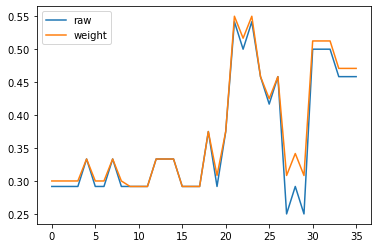

In [23]:
# Raw vs. weighted
# midi 以外分數分佈
prediction_without_midi_df.plot()

<AxesSubplot:>

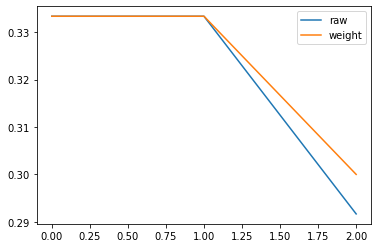

In [24]:
# midi 分數分佈
prediction_midi_df.plot()

## 加權分佈
從以下的加權分佈可以看到誤判為平行調的佔絕大多數。可能代表以最多出現次數的音視為主音的想法有一定的可靠度，但是每首樂曲可能因為時長不足，抑或曲風特性所致——爵士、藍調容易出現和弦外音可能剛巧反而符合相反大小調的音階分佈。

而判斷為完全五度及關係調的原因，可能是主音原本就找錯了（在以出現最多次的音作為主音的規則下），導致最後的結果出錯。
但全部大小調都比對一次或許也太過耗時，兩種作法間需做權衡。

In [25]:

weighted_distribution_midi = {"midi":weighted_distribution['midi']}
print(weighted_distribution_midi)

weighted_distribution_without_midi = weighted_distribution
del weighted_distribution['midi']

weighted_distribution_without_midi_df = pd.DataFrame.from_dict({(i, j, k): weighted_distribution_without_midi[i][j][k] 
                            for i in weighted_distribution_without_midi.keys() 
                            for j in weighted_distribution_without_midi[i].keys()
                            for k in weighted_distribution_without_midi[i][j].keys()
                            }, orient='columns').T

weighted_distribution_without_midi_df.reset_index(inplace=True)
weighted_distribution_without_midi_df.columns = ['format', 'chroma_operation', 'template_type', 'weighted_count_fifth', 'weighted_count_relative', 'weighted_count_parallel']

print(tabulate(weighted_distribution_without_midi_df, headers='keys', tablefmt='fancy_grid'))

{'midi': {'binary': {'fifth': 0, 'relative': 0, 'parallel': 0}, 'ks': {'fifth': 0, 'relative': 0, 'parallel': 0}, 'harmonic': {'fifth': 0, 'relative': 0, 'parallel': 1}}}
╒════╤══════════╤════════════════════╤═════════════════╤════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│    │ format   │ chroma_operation   │ template_type   │   weighted_count_fifth │   weighted_count_relative │   weighted_count_parallel │
╞════╪══════════╪════════════════════╪═════════════════╪════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│  0 │ HU33     │ stft               │ binary          │                      0 │                         0 │                         1 │
├────┼──────────┼────────────────────┼─────────────────┼────────────────────────┼───────────────────────────┼───────────────────────────┤
│  1 │ HU33     │ stft               │ ks              │                      0 │                         0 │                         1 │
├

In [26]:
print(weighted_distribution_midi)
weighted_distribution_midi_df = pd.DataFrame.from_dict({(i, j): weighted_distribution_midi[i][j]
                            for i in weighted_distribution_midi.keys()
                            for j in weighted_distribution_midi[i].keys()
                            }, orient='columns').T

weighted_distribution_midi_df.reset_index(inplace=True)
weighted_distribution_midi_df.columns = ['format', 'template_type', 'weighted_count_fifth', 'weighted_count_relative', 'weighted_count_parallel']
print(weighted_distribution_midi_df)
print(tabulate(weighted_distribution_midi_df, headers='keys', tablefmt='fancy_grid'))

{'midi': {'binary': {'fifth': 0, 'relative': 0, 'parallel': 0}, 'ks': {'fifth': 0, 'relative': 0, 'parallel': 0}, 'harmonic': {'fifth': 0, 'relative': 0, 'parallel': 1}}}
  format template_type  weighted_count_fifth  weighted_count_relative  \
0   midi        binary                     0                        0   
1   midi            ks                     0                        0   
2   midi      harmonic                     0                        0   

   weighted_count_parallel  
0                        0  
1                        0  
2                        1  
╒════╤══════════╤═════════════════╤════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│    │ format   │ template_type   │   weighted_count_fifth │   weighted_count_relative │   weighted_count_parallel │
╞════╪══════════╪═════════════════╪════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│  0 │ midi     │ binary          │                      0 │         

<AxesSubplot:>

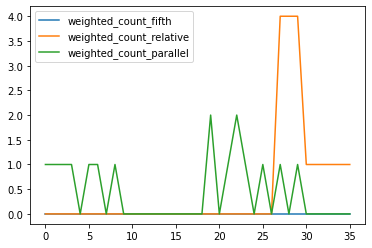

In [27]:
weighted_distribution_without_midi_df.plot()

## 不同演奏錄音

此次作業須使用四個不同表演的錄音 Audio 檔案以及 midi 檔案，來進行 key detection。<br/>
根據不同表演及檔案格式，得到以下分數。<br/>

使用讀取 midi 檔案的方式來進行 key detection 與 HU33, SC06 (兩者皆為 wav 檔案) 的分數較相近，大概只高了0.01 的分數，而 mp3 格式的檔案得到了平均 0.4 以上的分數，高了 0.1 左右可以說是不小的差距。
但這樣的結果與我自身的預期有出入，理由有數個，首先 mp3 檔案為不可逆壓縮格式，而 wav 則是與錄音當下的設備環境保有同樣的音質，所以 wav 的檔案大小比 mp3 大且語音訊號沒有經過壓縮，所以音質不會出現失真的情況。因此原先預期 wav 的效果應該會比 mp3 來得好，但實際結果並非如此。<br/>

但實際上會影響 detection 分數的因素不僅有檔案格式，還有錄音環境和設備的差異。<br/>
在聽過四種錄音檔案後可以發現：<br/>
● SC06 的檔案響度較小，音質清澈環境，但可能因為錄音距離較遠且採樣較細緻所以環境底噪（翻譜、腳步移動、踏板聲較清晰），推測此錄音應該釋教接近現在年份的，但或許太過細緻的錄音也會收錄許多的雜音，進而導致音訊取樣資料上的變異性及不確定性。<br/>
● HU33 響度更小且雜音十分明顯，感覺是年代非常久遠的錄音檔案，可能是受到過去錄音設備品質的限制，導致音訊資料雜音幾乎可以說比演奏更清楚，而這些人耳聽起來只是「嘈雜」的噪音，對電腦而言都是具有相對應音高的，因此在提取 chromagram 特徵時這些噪音應該便會造成能量分佈失真。<br/>
● FI80 的檔案響度較前兩者就大很多，音場上的感受人聲在收錄時偏右鋼琴偏左，且聽起來的音質乾淨清澈，錄音年代也應較接近現在，雖然是使用 mp3 這樣的壓縮檔案格式，但只要是這樣清晰的錄音對於電腦而言也會降低許多干擾，使偵測結果有較好的表現。<br/>
● FI66 的檔案響度再較 FI80 大一點，感覺與人聲錄音的距離較近，但是人耳聽起來有較明顯的雜訊，但應該也只是受到錄音設備限制，其在收錄上的表現較清晰，錄音時離樂器和演唱加較近也可以避免收錄到音樂以外的雜音。<br/>

因此總結出可能有幾個因素導致結果與預期相左，首先是錄音當下的年份及設備限制，再者是錄音當下的收音設備擺放的位置遠近，以及檔案格式未必會影響辨識結果，反而主要是錄音設備、環境和音質才是影響辨識結果的關鍵因素。

In [28]:
group_by_format = prediction_without_midi_df.groupby("format")
print(group_by_format.mean())

group_by_format_midi = prediction_midi_df.groupby("format")
print(group_by_format_midi.mean())

concat_item = [group_by_format.mean(), group_by_format_midi.mean()]
result_group_by_format = pd.concat(concat_item)

print(result_group_by_format)

             raw    weight
format                    
FI66    0.439816  0.446296
FI80    0.407407  0.434259
HU33    0.300928  0.307407
SC06    0.305557  0.305556
             raw    weight
format                    
midi    0.319443  0.322222
             raw    weight
format                    
FI66    0.439816  0.446296
FI80    0.407407  0.434259
HU33    0.300928  0.307407
SC06    0.305557  0.305556
midi    0.319443  0.322222


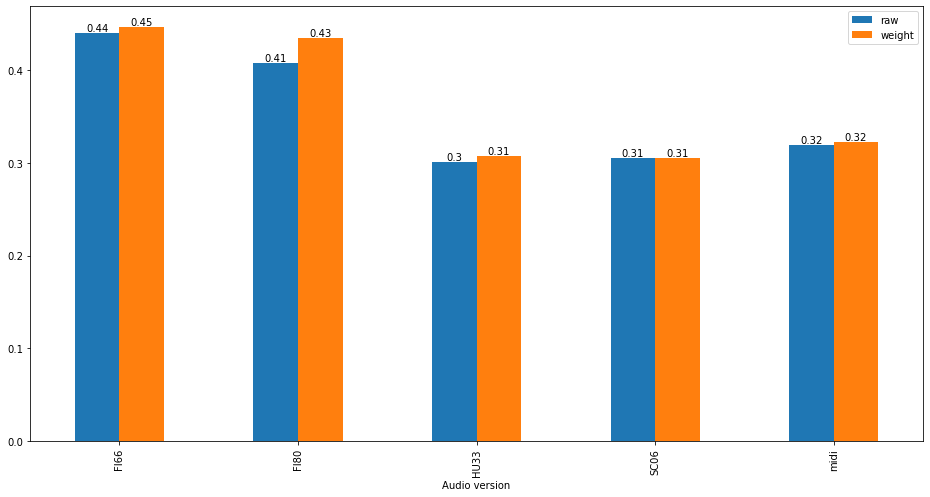

In [29]:
ax = result_group_by_format.plot(kind='bar', figsize=(16, 8))

for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax.set_xlabel('Audio version')

## 不同 template 形式
使用三種 template 建立方式來進行 24 種大小調的理想 chromagram template 分佈狀態， binary, ks 以及 harmonic template。<br/>
一個八度中採用 12 平均律可分為 12 個音高： C, C#, D, D#, E, F, F#, G, G#, A, A#, B<br/>

### Binary
理想情況下，同一曲調中出現的音將會呈現固定的音階形式，而大調和小調為其中兩種形式。<br/>
binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]<br/>
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]<br/>

### K-S
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]<br/>
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]<br/>

### Harmonic
首先計算出 C ~ B 中 12 個音的泛音列，使用以下公式計算：<br/>
U<sub>C</sub> = [1 + α + α<sup>3</sup> + α<sup>7</sup>, 0, 0, 0, α<sup>4</sup>, 0, 0, α<sup>2</sup> + α<sup>5</sup>, 0, 0, α<sup>6</sup>, 0]<br/>
U<sub>C#</sub> = [0, 1 + α + α<sup>3</sup> + α<sup>7</sup>, 0, 0, 0, α<sup>4</sup>, 0, 0, α<sup>2</sup> + α<sup>5</sup>, 0, 0, α<sup>6</sup>] ，如此向右進行 circular shift 以此類推。<br/>
之後再根據 binary template 進行泛音列加總：<br/>
C<sub>Major</sub> = U<sub>C</sub> + U<sub>D</sub> + U<sub>E</sub> + U<sub>F</sub> + U<sub>G</sub> + U<sub>A</sub> + U<sub>B</sub><br/>
C<sub>minor</sub> = U<sub>C#</sub> + U<sub>D#</sub> + U<sub>E</sub> + U<sub>F#</sub> + U<sub>G#</sub> + U<sub>A#</sub> + U<sub>B#</sub> ，以此類推

從下圖可以看出 binary　和　KS template 可以得到三者中最好的表現。

In [30]:
group_by_template_type = prediction_without_midi_df.groupby("template_type")
print(group_by_template_type.mean())

group_by_template_type_midi = prediction_midi_df.groupby("template_type")
print(group_by_template_type_midi.mean())

result_group_by_template_type = pd.concat([group_by_template_type.mean(), group_by_template_type_midi.mean()]).groupby('template_type').agg({'raw':'mean', 'weight':'mean'})
print(result_group_by_template_type)

                    raw    weight
template_type                    
binary         0.364584  0.374306
harmonic       0.364584  0.374306
ks             0.361112  0.371528
                   raw    weight
template_type                   
binary         0.33333  0.333333
harmonic       0.29167  0.300000
ks             0.33333  0.333333
                    raw    weight
template_type                    
binary         0.348957  0.353819
harmonic       0.328127  0.337153
ks             0.347221  0.352431


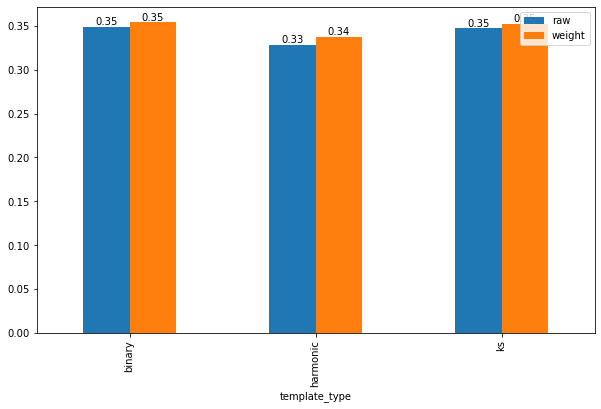

In [31]:
ax = result_group_by_template_type.plot(kind='bar', figsize=(10, 6))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

## 不同 spectrogram 擷取方法
透過不同的時頻圖轉換方式，STFT、CQT 及 CENS 獲得 spectrogram 後再轉換為 chromagram。

● STFT：先將輸入訊號分成多個很短的固定時間區塊，透過 window function 的運算，取得 local time window 作瞬時的頻譜近似，每一個時間點都透過傅立葉轉換得到其對應的頻譜。
在此作業使用 window length = 4096 ，是因為 window 長度越能分辨精確的頻率。但當要處理的頻率域範圍非常廣，有些音比較長有些音比較短，較難把每個頻率都準確抓出。<br/>
● CQT：如果同一時間有很高音跟很低音同時出現， 但 window 較大適合處理低音，較小適合處理高音，無法兩全其美。使用 CQT 的目標在於對於不同頻帶都要做頻譜分析，每個 moment 都取不同長度的 window 作傅立葉轉換，雖然較麻煩但也較能處理同時出現的高低音分析。採用 log frequency scale，依照 12 平均律在一個八度內取 12 個 scale 。<br/>
● CENS(Chroma Energy Normalized)：CENS 的主要目標是在較長的 window 範圍上進行統計，可以平滑化節奏、發聲和音樂中的裝飾音（ex:顫音和琶音）所造成的局部偏差。chromagram 上可以看出比以上兩者更平滑。<br/>

在下圖中可以看出 CQT 在此資料集上的效果最好，其次是 CENS。<br/>
midi file 是直接透過 pretty midi 之中的函式取得 chromagram，而不是像 audio file 一樣，所以以下只有針對 midi 以外的檔案進行分析。

In [32]:
group_by_chroma_operation = prediction_without_midi_df.groupby("chroma_operation")
group_by_chroma_operation.mean()

,raw,weight
chroma_operation,,
cens,0.375000,0.380208
cqt,0.416667,0.423958
stft,0.298613,0.315972


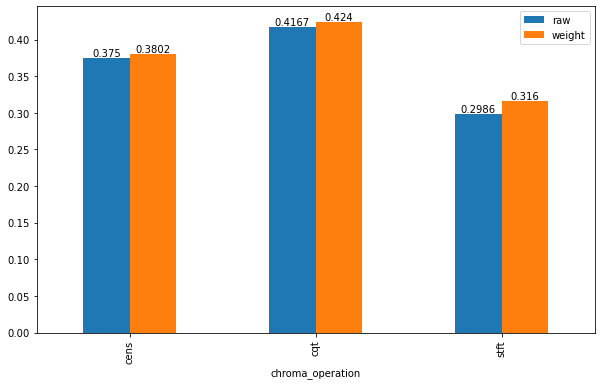

In [33]:
group_by_chroma_operation_mean = group_by_chroma_operation.mean()

ax = group_by_chroma_operation_mean.plot(kind='bar', figsize=(10, 6))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=4), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')